In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from modAL.uncertainty import uncertainty_sampling
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np

from src import model, data, train, visualization

In [21]:
x_train, y_train = data.prepare_data('./data/train_32x32.mat')
x_test, y_test = data.prepare_data('./data/test_32x32.mat')

test_dataset = data.SVHNDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

split = int(0.8 * len(x_train))
x_train, y_train, x_val, y_val = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

val_dataset = data.SVHNDataset(x_val, y_val)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

x_pool, y_pool = list(zip(*train_data))
x_pool = torch.tensor(x_pool)
y_pool = torch.tensor(y_pool)

x_train, x_pool = x_pool[:1000], x_pool[1000:]
y_train, y_pool = y_pool[:1000], y_pool[1000:]

In [7]:
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=32, shuffle=False)

cnn_model = model.DropoutCNN(0.2)
loss_fn = torch.nn.CrossEntropyLoss()

torch.manual_seed(42)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.01)

In [8]:
checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 40, loss_fn, optimizer, disable_logs=False)

  0%|          | 0/40 [00:00<?, ?it/s]

After epoch 0, avg training loss is 4.5068, avg validation loss is 2.8862, acc on train set is 11.20% and acc on validation set is 10.77%
After epoch 1, avg training loss is 2.6065, avg validation loss is 2.3637, acc on train set is 10.50% and acc on validation set is 11.56%
After epoch 2, avg training loss is 2.3262, avg validation loss is 2.3565, acc on train set is 13.00% and acc on validation set is 11.39%
After epoch 3, avg training loss is 2.2920, avg validation loss is 2.3326, acc on train set is 15.90% and acc on validation set is 13.90%
After epoch 4, avg training loss is 2.2810, avg validation loss is 2.3173, acc on train set is 18.00% and acc on validation set is 13.17%
After epoch 5, avg training loss is 2.2360, avg validation loss is 2.5989, acc on train set is 18.70% and acc on validation set is 12.45%
After epoch 6, avg training loss is 2.0737, avg validation loss is 1.9983, acc on train set is 25.10% and acc on validation set is 29.65%
After epoch 7, avg training loss i

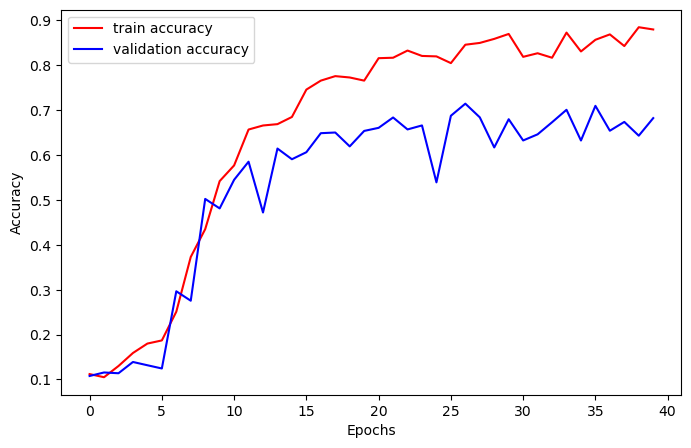

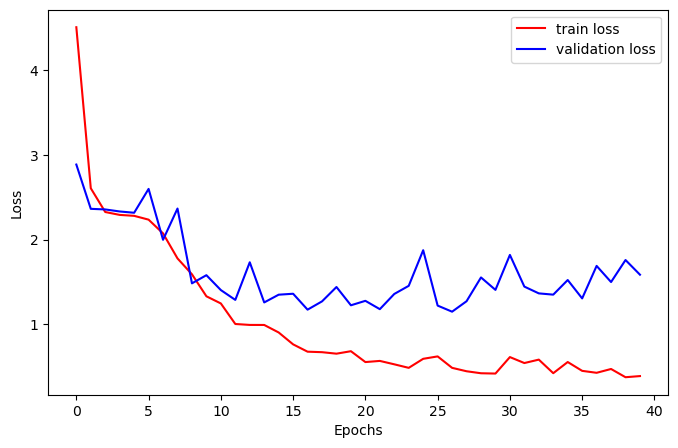

In [9]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])

In [10]:


trained_model = model.DropoutCNN(0.2)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, _, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 70.5705%, test loss: 1.1840


In [13]:
trained_model.eval()

with torch.inference_mode():
    samples = uncertainty_sampling(trained_model, x_pool, 1000)

In [22]:
x_train = np.concatenate((x_train, np.take(x_pool, samples[0], axis=0)), axis=0)
y_train = np.concatenate((y_train, np.take(y_pool, samples[0], axis=0)), axis=0)
x_train.shape

(2000, 1, 32, 32)

In [23]:
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=32, shuffle=False)

cnn_model = model.DropoutCNN(0.2)
loss_fn = torch.nn.CrossEntropyLoss()

torch.manual_seed(42)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.01)

In [24]:
checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 40, loss_fn, optimizer, disable_logs=False)

  0%|          | 0/40 [00:00<?, ?it/s]

After epoch 0, avg training loss is 3.3701, avg validation loss is 2.4076, acc on train set is 10.65% and acc on validation set is 9.45%
After epoch 1, avg training loss is 2.3691, avg validation loss is 2.3573, acc on train set is 12.45% and acc on validation set is 10.46%
After epoch 2, avg training loss is 2.3220, avg validation loss is 2.3603, acc on train set is 12.80% and acc on validation set is 10.22%
After epoch 3, avg training loss is 2.3195, avg validation loss is 2.3448, acc on train set is 12.10% and acc on validation set is 10.73%
After epoch 4, avg training loss is 2.2993, avg validation loss is 2.3493, acc on train set is 13.70% and acc on validation set is 10.32%
After epoch 5, avg training loss is 2.2864, avg validation loss is 2.3764, acc on train set is 14.65% and acc on validation set is 10.66%
After epoch 6, avg training loss is 2.2670, avg validation loss is 2.3283, acc on train set is 14.65% and acc on validation set is 11.97%
After epoch 7, avg training loss is

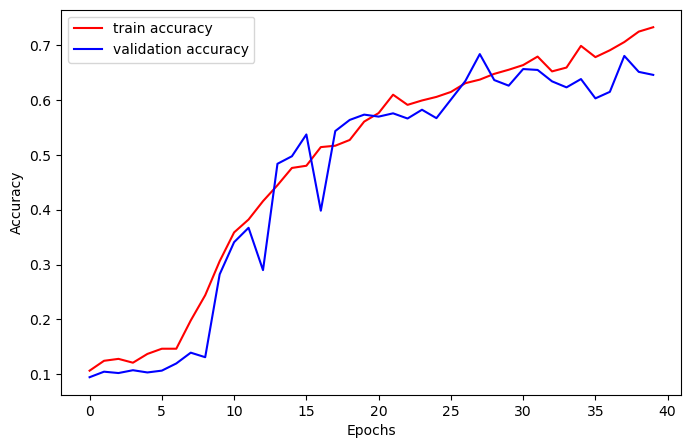

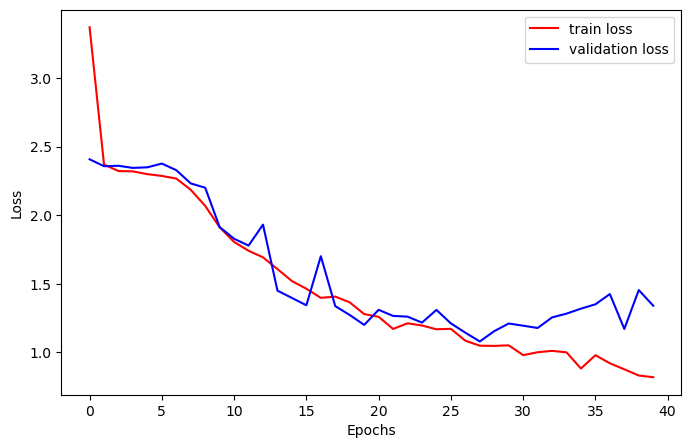

In [25]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])
visualization.loss_plot(history['train_loss'], history['valid_loss'])

In [26]:
trained_model = model.DropoutCNN(0.2)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, _, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 65.4420%, test loss: 1.1557


In [27]:
x_pool = np.delete(x_pool, samples[0], axis=0)
y_pool = np.delete(y_pool, samples[0], axis=0)